From previous experiment, we found the difficulty in predicitng stock price. 
Therefore, this is the stock return prediction using supervised learning\(dataset: Starbacks stock 2013-2018)\
I have taken two different approach for each method 
- One step forecast
- Multistep forecast

As the results show, the prediciton is just copying the previous value. In the next experiment, I am going to simplify the expected result as just predicting the next price will go up/down by binary classification.
\
I have tried \
- LSTM
In conclusion, as it proved, it is not quite feasible to predict return by using these model and method. 

In [1]:
import tensorflow as tf
print('tf version: ', tf.__version__)

tf version:  2.11.0


In [2]:
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

In [4]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [ ]:
#calculate returns by shifting the data
df['PrevClose'] = df['close'].shift(1) #move everything down 1

#so now it is like
#close / prev close
#x[2] x[1]


In [7]:
df.head() 

,date,open,high,low,close,volume,Name,PrevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [8]:
#Then retun is

#(x[t] - x[t-1] / x[t-1])
df['Return'] = (df['close'] - df['PrevClose']) / df['PrevClose']

In [9]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


<Axes: >

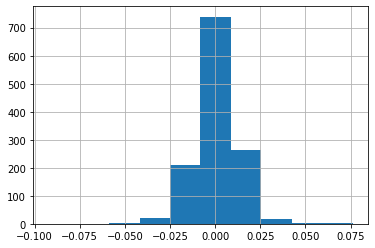

In [11]:
#Now, observe in histgram
df['Return'].hist()

Normalize the dataset

In [12]:
series = df['Return'].values[1:].reshape(-1, 1)

#Normalize the data
#Note:This boundary is just random approximation
scaler = StandardScaler()
scaler.fit(series[:len(series)//2])
series = scaler.transform(series).flatten()


Build Dataset

In [13]:
##Build dataset
#Let's see if we can use T past values to predict the next value
T = 10 
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t: t+T]
  X.append(x)
  y = series[t + T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1 )# Now the data shouls be N x T x D
Y = np.array(Y)
N = len(X)
print('X_shape: ', X.shape, 'Y_shape: ', Y.shape)

X_shape:  (1248, 10, 1) Y_shape:  (1248,)


Try Autoregressive RNN model

In [14]:
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
    loss='mse',
    optimizer=Adam(0.1),
)

##Train Model
r = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs=80,
    validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/80
20/20 [==============================] - 3s 39ms/step - loss: 1.0004 - val_loss: 1.1423
Epoch 2/80
20/20 [==============================] - 0s 11ms/step - loss: 1.0086 - val_loss: 1.1455
Epoch 3/80
20/20 [==============================] - 0s 11ms/step - loss: 0.9925 - val_loss: 1.1547
Epoch 4/80
20/20 [==============================] - 0s 11ms/step - loss: 0.9891 - val_loss: 1.1459
Epoch 5/80
20/20 [==============================] - 0s 9ms/step - loss: 0.9857 - val_loss: 1.1477
Epoch 6/80
20/20 [==============================] - 0s 10ms/step - loss: 0.9890 - val_loss: 1.1370
Epoch 7/80
20/20 [==============================] - 0s 10ms/step - loss: 0.9863 - val_loss: 1.1648
Epoch 8/80
20/20 [==============================] - 0s 11ms/step - loss: 0.9956 - val_loss: 1.1419
Epoch 9/80
20/20 [==============================] - 0s 11ms/step - loss: 0.9941 - val_loss: 1.1401
Epoch 10/80
20/20 [==============================] - 0s 10ms/step - loss: 0.9843 - val_loss: 1.2005
Epoch 11/8

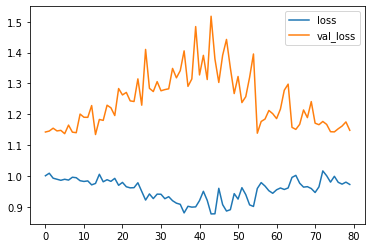

In [15]:
#Plot loss per iteration
plt.plot(r.history['loss'], label="loss")
plt.plot(r.history['val_loss'], label="val_loss")
plt.legend()

39/39 [==============================] - 1s 3ms/step
(1248, 1)


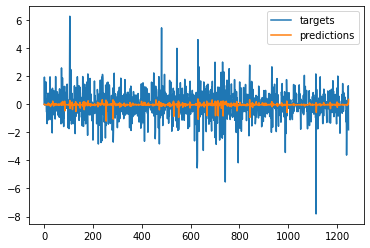

In [16]:
##One Step Forecast
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:, 0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

Multi step forecast

1/1 [==============================] - 0s 51ms/step


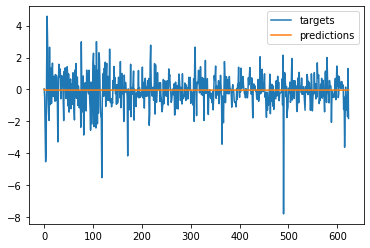

In [17]:
validation_target = Y[-N//2:]
validation_predictions = []

#last train input
last_x = X[-N//2] #1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] #1x1 aray -> scalar

  #Update the predction list
  validation_predictions.append(p)

  #make new input

  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='targets')
plt.plot(validation_predictions, label='predictions')
plt.legend()
plt.show()